<a href="https://colab.research.google.com/github/kaverichavan/NNDL_2022/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries and reading csv files 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/monthly_milk_production.csv',index_col='Date',parse_dates=True)   
#Date is not  string
df.index.freq='MS' 

Displaying the top 5 rows

In [5]:
df.head()     #month wise production data will be displayed

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


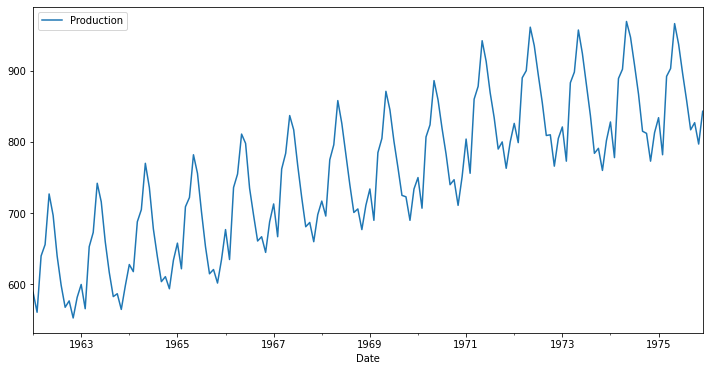

In [6]:
df.plot(figsize=(12,6))

Importing seasonal decompose - Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


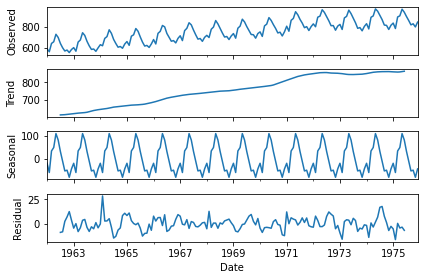

In [8]:
results = seasonal_decompose(df['Production'])
results.plot();

In [10]:
len(df)

168

iloc - Purely integer-location based indexing for selection by position.

In [11]:
train = df.iloc[:156]        # all data except the last 12 months data 168-12=156
test = df.iloc[156:]         # Last 12 months data

MinMaxScaler - Transform features by scaling each feature to a given range.

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
df.head(),df.tail()       #magnitude of the production values not in proper range

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:10]    # transform method covert the values in the 0...1.

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

TimeseriesGenerator - Creates a dataset of sliding windows over a timeseries provided as array.

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

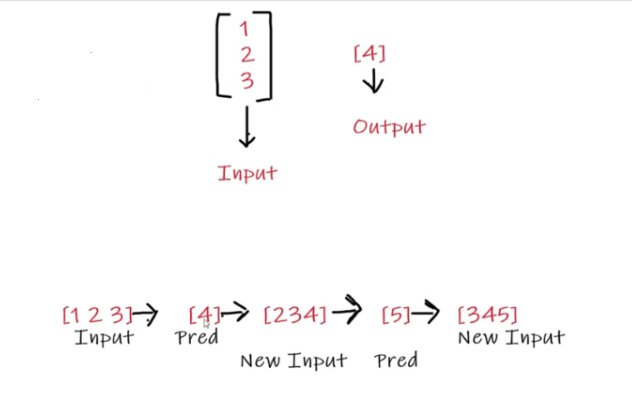

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [19]:
X.shape        # 1 row 3 columns and 1 feature

(1, 3, 1)

In [20]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit model
model.fit(generator,epochs=50)  #generator creates batches of 3-3 inputs and using that predi

Epoch 1/50
144/144 [==============================] - 4s 12ms/step - loss: 0.0385
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0229
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0187
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0137
Epoch 5/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0116
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0062
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 8/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 10/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0052
Epoch 11/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 12/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 13/50
144/144 [===

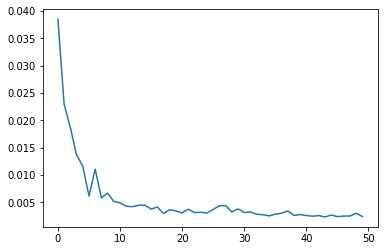

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
last_train_batch = scaled_train[-12:]
 #taking last 12 months values in training set to make 
 #prediction for 1st value in test set

In [27]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch)

array([[0.65576315]], dtype=float32)

In [29]:
scaled_test[0]     
 # original value was 0.67 model predicted it to be 0.65

array([0.67548077])

In [30]:
test_predictions = []     #empty list of test predictions

first_eval_batch = scaled_train[-n_input:]      
#last 12 values from the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
test_predictions

[array([0.65576315], dtype=float32),
 array([0.65670985], dtype=float32),
 array([0.81928766], dtype=float32),
 array([0.8884613], dtype=float32),
 array([0.98211664], dtype=float32),
 array([0.96957827], dtype=float32),
 array([0.9066244], dtype=float32),
 array([0.8106757], dtype=float32),
 array([0.70677006], dtype=float32),
 array([0.65495765], dtype=float32),
 array([0.6010794], dtype=float32),
 array([0.6445859], dtype=float32)]

In [32]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


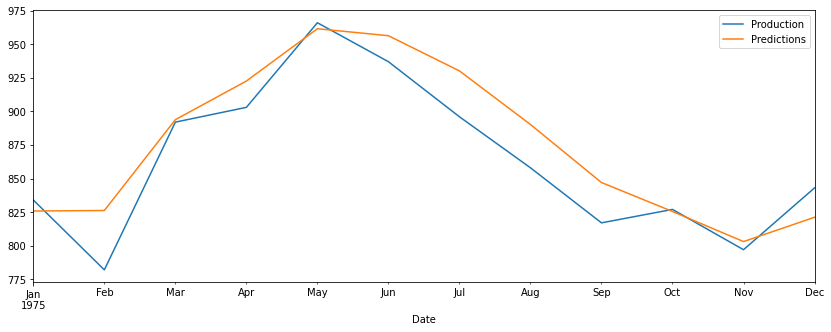

In [35]:
test.plot(figsize=(14,5))

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

23.139278384708643
